In [23]:
import cv2
import matplotlib 
import numpy as np
from ParametricLights import  extract_lights_from_equirectangular_image
from PIL import Image 
from ezexr import imread
import torch

In [4]:
def draw_lights_on_image(I_,light_params):
    from matplotlib import cm
    cnt = 1
    N = len(light_params)
    I=I_.copy()
    for l_ in light_params:
        l = l_[0]
        clr = np.asarray(cm.hot(cnt)[0:3])*255 * 5

        cv2.ellipse(I, (int(l[0]), int(l[1])), (int(l[2]), int(l[3])), int(l[4]), 0, 360, clr)
        cv2.circle(I, (int(l[0]), int(l[1])), 2, clr, -1)
        cnt += 1

    return I*255

In [5]:
def create_equirectangular_image_with_blob(lat,long,radius,noise=0.0):
    v = int(lat/180.0*128)
    u = int(long/360.0*256)
    im = np.random.uniform(0.0, noise, (128, 256, 3))
    cv2.circle(im, (u,v), radius, (10, 10, 10), -1)
    im = cv2.GaussianBlur(im, (19, 19), -1)
    return im


In [6]:
im1 = create_equirectangular_image_with_blob(90,45,3,noise=0.1)
im2 = create_equirectangular_image_with_blob(90,45+180,3,noise=0.1)


In [7]:
l1 = extract_lights_from_equirectangular_image(im1)

In [8]:
im1_vis = draw_lights_on_image(im1, l1)


31.45969581604004
63.38334655761719


In [9]:
im1_vis = Image.fromarray(im1_vis.astype(np.uint8))

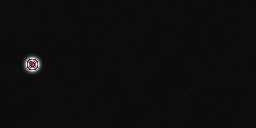

In [112]:
display(im1_vis)

287.09063720703125
157.0421905517578
11.706778526306152
126.86589050292969
498.3720397949219
124.73946380615234


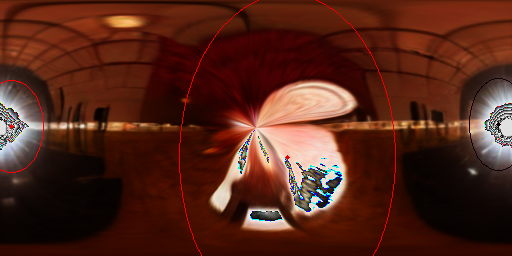

In [19]:
envmap = imread('../../datasets/face/face2000_single/exr/00000/00032.exr')
l1 = extract_lights_from_equirectangular_image(envmap)
envmap_viz = draw_lights_on_image(envmap, l1)
envmap_viz = Image.fromarray(envmap_viz.astype(np.uint8))
display(envmap_viz)


In [20]:
idx = 32 

In [24]:
def applySHlight(normal_images, sh_coeff):
  N = normal_images
  sh = torch.stack(
    [
      N[0] * 0.0 + 1.0,
      N[0],
      N[1],
      N[2],
      N[0] * N[1],
      N[0] * N[2],
      N[1] * N[2],
      N[0] ** 2 - N[1] ** 2,
      3 * (N[2] ** 2) - 1,
    ],
    0,
  )  # [9, h, w]
  pi = np.pi
  constant_factor = torch.tensor(
    [
      1 / np.sqrt(4 * pi), #confirmed
      ((2 * pi) / 3) * (np.sqrt(3 / (4 * pi))),
      ((2 * pi) / 3) * (np.sqrt(3 / (4 * pi))),
      ((2 * pi) / 3) * (np.sqrt(3 / (4 * pi))),
      (pi / 4) * (3) * (np.sqrt(5 / (12 * pi))),
      (pi / 4) * (3) * (np.sqrt(5 / (12 * pi))),
      (pi / 4) * (3) * (np.sqrt(5 / (12 * pi))),
      (pi / 4) * (3 / 2) * (np.sqrt(5 / (12 * pi))),
      (pi / 4) * (1 / 2) * (np.sqrt(5 / (4 * pi))),
    ]
  ).float()
  sh = sh * constant_factor[:, None, None]

  shading = torch.sum(
    sh_coeff[:, :, None, None] * sh[:, None, :, :], 0
  )  # [9, 3, h, w]

  return shading

def genSurfaceNormals(n):
  x = torch.linspace(-1, 1, n)
  y = torch.linspace(1, -1, n)
  y, x = torch.meshgrid(y, x)

  z = (1 - x ** 2 - y ** 2)
  mask = z < 0
  z[mask] = 0
  z = torch.sqrt(z)
  return torch.stack([x, y, z], 0), mask

def applySHlightXYZ(xyz, sh):
  out = applySHlight(xyz, sh)
  return out 

def drawSphere(sh, img_size=256, is_back=False, white_bg=False):
  n = img_size
  xyz, mask = genSurfaceNormals(n)
  if(is_back):
    xyz[2] = xyz[2] * -1
  if white_bg:
    xyz[:, mask] = 1
  out = applySHlightXYZ(xyz, sh)
  out[:, xyz[2] == 0] = 0
  return out

In [31]:
def drawMap(sh, img_size=256):

  n = img_size
  lr = torch.linspace(0, 2 * np.pi, 2 * n)
  ud = torch.linspace(0, np.pi, n)
  ud, lr = torch.meshgrid(ud, lr)

  # we want to make the sphere unwrap at the center of this map,
  # so the left-most column is the furthest-away point on the sphere
  # lr going counter-clockwise = increasing in value.
  # ud starting from 0 (top) to pi (bottom).
  # Lattitude = azimuth = deg from one of xz axis
  # Longtitude = elevation = deg from y-axis
  # In standard unitsphere orientation;
  # z = up (so set y = pt(cos(ud))) ref. https://www.learningaboutelectronics.com/Articles/Spherical-to-cartesian-rectangular-coordinate-converter-calculator.php
  x = -torch.sin(ud) * torch.sin(lr)  # Negative to ensure correct left-right orientation
  y = torch.cos(ud)                # No negative sign needed for up-down orientation
  z = -torch.sin(ud) * torch.cos(lr)  # Negative to ensure correct front-back orientation

  lm = n // 2
  rm = n + (n // 2)

  out = applySHlightXYZ(torch.stack([x, y, z], 0), sh)
  out_centered = out[:, :, lm:rm].clone()
  out_clean = out.clone()
  out[:, :, lm] = torch.tensor((1, 0, 0))[:, None]
  out[:, :, rm] = torch.tensor((1, 0, 0))[:, None]
  return out, out_centered, out_clean

In [32]:
def process_image(idx):
    subdir_id = idx // 1000
    light = np.load(f"../../datasets/face/face2000_single/light/{subdir_id*1000:05d}/{idx:05d}_light.npy")
    sh_viz = drawMap(torch.tensor(light)).permute(1,2,0).numpy()
    return sh_viz

In [33]:
process_image(idx)

NameError: name 'pt' is not defined